In [2]:
import sys
import numpy as np
import scipy.optimize as opt
import pandas as pd
from matplotlib import pyplot as plt, animation
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import proplot as plot
import seaborn as sns
from tqdm import tqdm

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import envelope_analysis as ea
from tools import plotting as myplt
from tools import animation as myanim
from tools import utils

sys.path.append('/Users/46h/Research/code/accphys/pyorbit_studies/measurement/')
from data_analysis import to_vec, to_mat, reconstruct_moments

In [25]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'
plot.rc['axes.grid'] = False

save_figures = False
def save(figname):
    if save_figures:
        plt.savefig(''.join(['_output/figures/', figname, '.png']), facecolor='white', dpi=250)

# 4D Measurement in RTBT
> This notebook reconstructs the beam covariance matrix at the entrance of the Ring to Target Beam Transport (RTBT) section of the Spallation Neutron Source (SNS).

<img src="_input/rtbt.png" width=800>

## Method summary

The goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:

$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from wire-scanner $i$ will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then directly related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{lm}$ are the elements of the transfer matrix. Taking 3 measurements with different optics settings between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $b$ from the measured moments and a $3N \times 10$ coefficient array $A$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, so if all these are used the coefficient array will be $15N \times 10$. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized. 

## RTBT lattice functions 

In [4]:
twiss = pd.read_csv('_output/data/twiss.dat')
ws_positions = np.loadtxt('_output/data/ws_positions.dat')

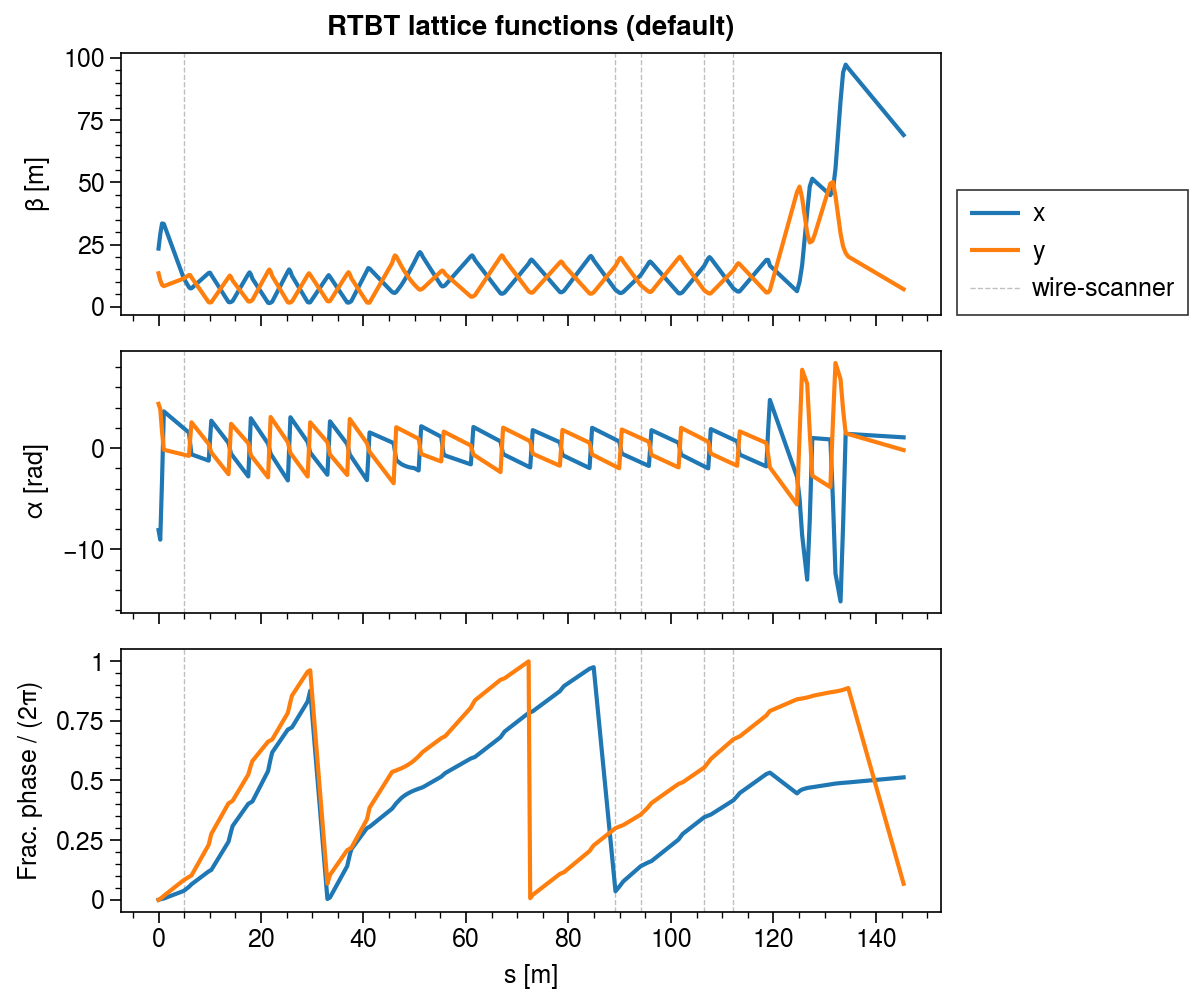

In [5]:
fig, axes = plot.subplots(nrows=3, figsize=(6, 5), spany=False)
ax1, ax2, ax3 = axes
twiss[['s','bx','by']].plot('s', ax=ax1, legend=False)
twiss[['s','ax','ay']].plot('s', ax=ax2, legend=False)
twiss[['s','nux','nuy']].plot('s', ax=ax3, legend=False)
axes.format(xlabel='s [m]', toplabels='RTBT lattice functions (default)', grid=False)
for ax, ylabel in zip(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', 'Frac. phase / ($2\pi$)']):
    ax.format(ylabel=ylabel);
    for ws_position in ws_positions:
        ax.axvline(ws_position, color='grey', ls='--', lw=0.5, alpha=0.5, zorder=0)
ax1.legend(labels=['x', 'y', 'wire-scanner'], ncols=1, loc=(1.02, 0));
save('twiss_default')

## Phase scan

In [6]:
ws_names = ['ws02', 'ws20', 'ws21', 'ws23', 'ws24']
active_ws_names = ws_names[:]

In [7]:
def load(handle, ws_name):
    path = '_output/data/{}_{}.npy'.format(handle, ws_name)
    return np.load(path)

phases_dict = {ws: load('phases', ws) for ws in ws_names}
moments_dict = {ws: 1e6 * load('moments', ws) for ws in ws_names}
transfer_mats_dict = {ws: load('transfer_mats', ws) for ws in ws_names}
env_params_dict = {ws: 1e3 * load('env_params', ws) for ws in ws_names}
coords_dict_dict = {ws: 1e3 * load('X', ws) for ws in ws_names}

phases = np.vstack([phases_dict[ws] for ws in active_ws_names])
moments = np.vstack([moments_dict[ws] for ws in active_ws_names]) # measured 
transfer_mats = np.vstack([transfer_mats_dict[ws] for ws in active_ws_names])
env_params = np.vstack([env_params_dict[ws] for ws in active_ws_names])
coords = np.vstack([coords_dict_dict[ws] for ws in active_ws_names])
    
Sigma0 = 1e6 * np.loadtxt('_output/data/Sigma0.dat')
X0 = 1e3 * np.loadtxt('_output/data/X0.dat')

Observe the beam at the wire-scanners. Any greyed-out wire-scanners are not used in the reconstruction.

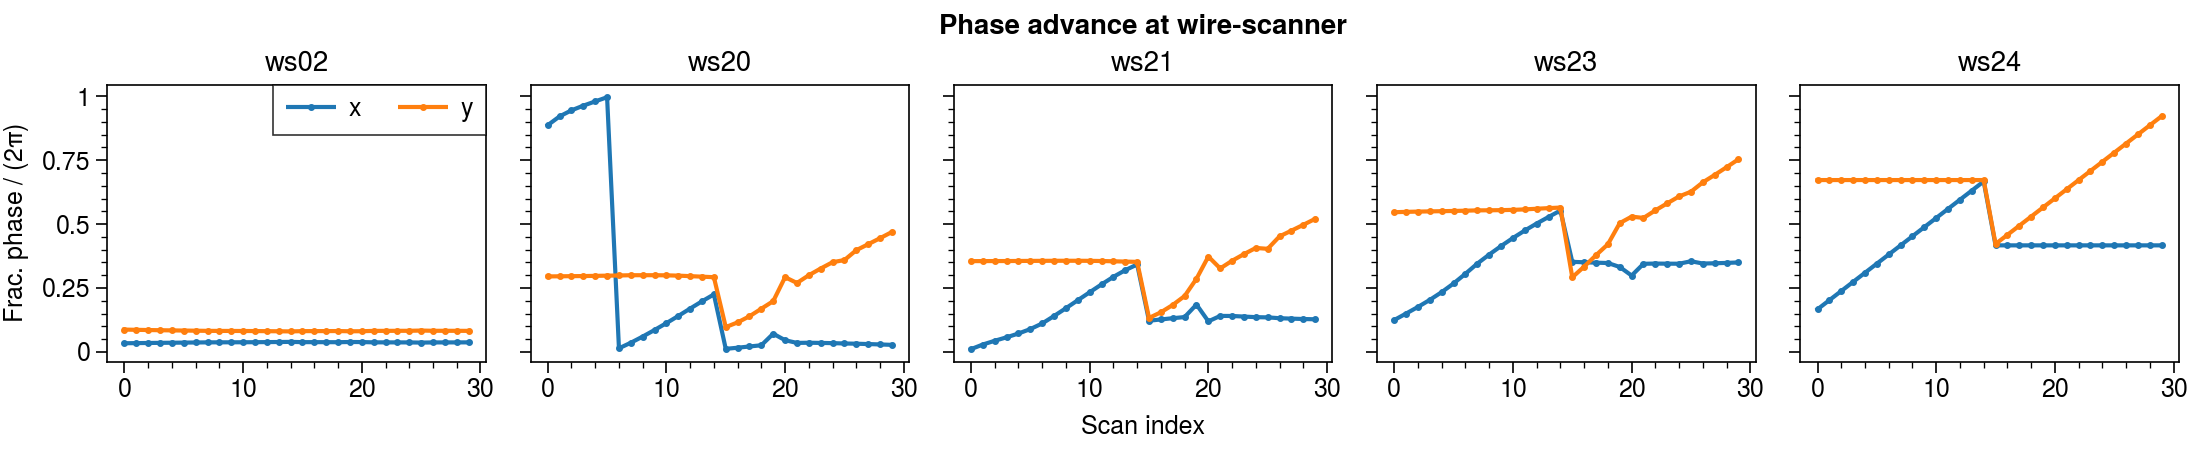

In [26]:
fig, axes = plot.subplots(ncols=5, figsize=(11, 2.25))
for ax, ws_name in zip(axes, ws_names):
    ax.plot(phases_dict[ws_name] % 1, marker='.', ms=3);
    ax.set_title(ws_name, color='grey' if ws_name not in active_ws_names else 'k')
axes.format(ylabel='Frac. phase / ($2\pi$)', xlabel='Scan index', suptitle='Phase advance at wire-scanner')
axes[0].legend(labels=['x', 'y'], ncols=3);
save('ws_phase_adv')

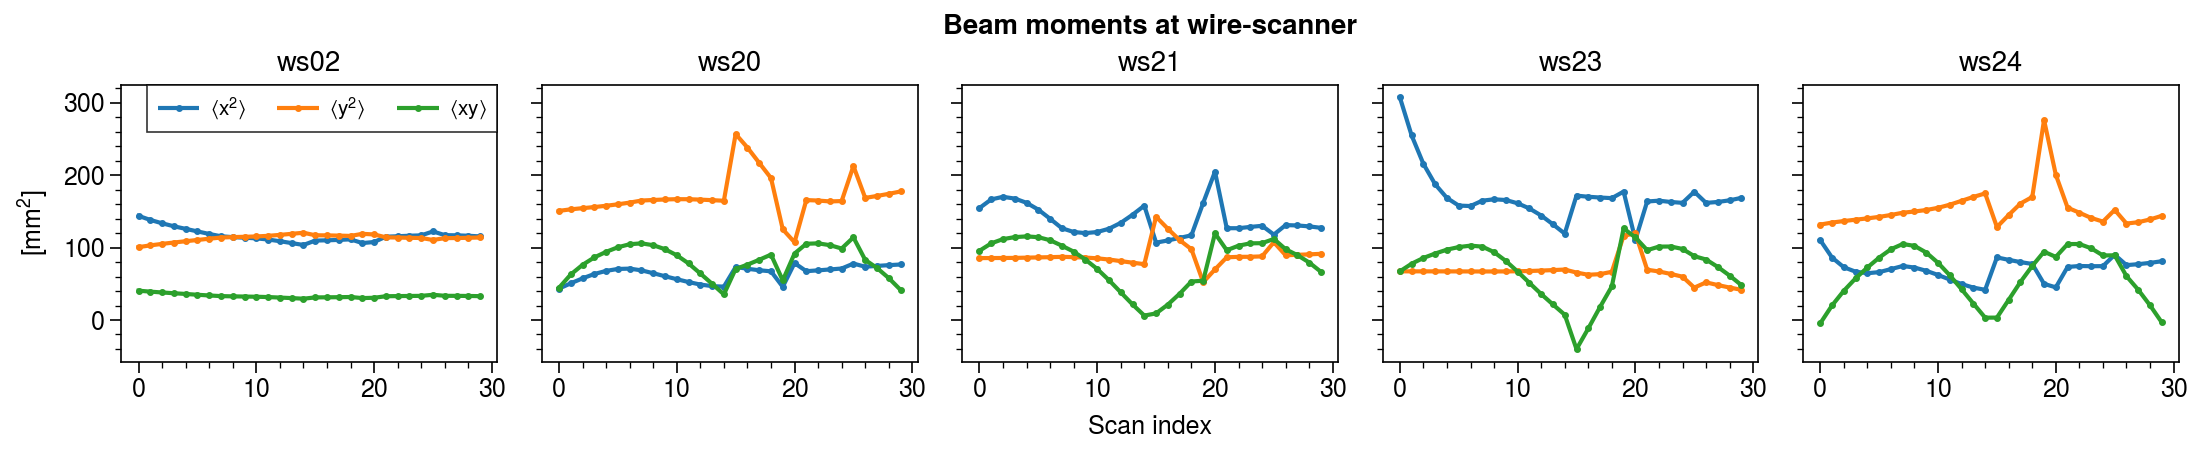

In [27]:
fig, axes = plot.subplots(ncols=5, figsize=(11, 2.25))
for ax, ws_name in zip(axes, ws_names):
    ax.plot(moments_dict[ws_name][:, 0], marker='.', ms=3)
    ax.plot(moments_dict[ws_name][:, 1], marker='.', ms=3)
    ax.plot(moments_dict[ws_name][:, 2], marker='.', ms=3)
    ax.set_title(ws_name, color='grey' if ws_name not in active_ws_names else 'k')
axes.format(ylabel='[mm$^2$]', xlabel='Scan index', suptitle='Beam moments at wire-scanner')
axes[0].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], fontsize='small');
save('ws_moments')

<center><b>Beam envelope at wire-scanner<b><center>

To do: 
* Add column below showing phase vs scan index.
* Add diagonal wire-scanner

In [45]:
ell_coords_list = [ea.get_ellipse_coords(env_params_dict[ws]) for ws in ws_names]

pad = 0.25
limits_list = np.array([(1 + pad) * myplt.get_u_up_max_global(coords) for coords in ell_coords_list])
umax, _ = np.max(limits_list, axis=0)

fig, ax_list = plt.subplots(ncols=6, figsize=(13, 1.75), sharex=True, sharey=True)
axes, text_ax = ax_list[:-1], ax_list[-1]
text_ax.grid(False)
myplt.despine([text_ax], 'all')
myplt.despine(axes)
axes[0].set_xlim(-umax, umax);  axes[0].set_ylim(-umax, umax)
axes[0].set_yticks(axes[0].get_xticks())
axes[0].set_xlabel('x [mm]');  axes[0].set_ylabel('y [mm]')
for ax, ws_name in zip(axes, ws_names):
    ax.set_title(ws_name, color='grey' if ws_name not in active_ws_names else 'k')
    ax.grid(False)
    ax.axvline(0, lw=0.2, c='k', alpha=0.2, zorder=99)
    ax.axhline(0, lw=0.2, c='k', alpha=0.2, zorder=99)
plt.close()

def update(t):
    for ax, coords in zip(axes, ell_coords_list):
        for patch in ax.patches:
            patch.remove()
        ax.fill(coords[t, :, 0], coords[t, :, 2], fc='lightsteelblue', ec='k', zorder=10)
    for ws, ax in zip(ws_names, axes):
        nux, nuy = phases_dict[ws][t]
        for text in ax.texts:
            text.set_visible(False)
        ax.annotate(r'$\nu_x = {:.2f}$'.format(nux), xy=(0.75, 0.85), xycoords='axes fraction')
        ax.annotate(r'$\nu_y = {:.2f}$'.format(nuy), xy=(0.75, 0.75), xycoords='axes fraction')
    for text in text_ax.texts:
        text.set_visible(False)
    text_ax.annotate('Scan index = {}'.format(t), xy=(0.25, 0.5), xycoords='axes fraction', horizontalalignment='center')

nframes = ell_coords_list[0].shape[0]
anim = animation.FuncAnimation(fig, update, frames=nframes, interval=1000/1)
if save_figures:
     anim.save('_output/figures/ws_envelope.mp4', dpi=300)
anim

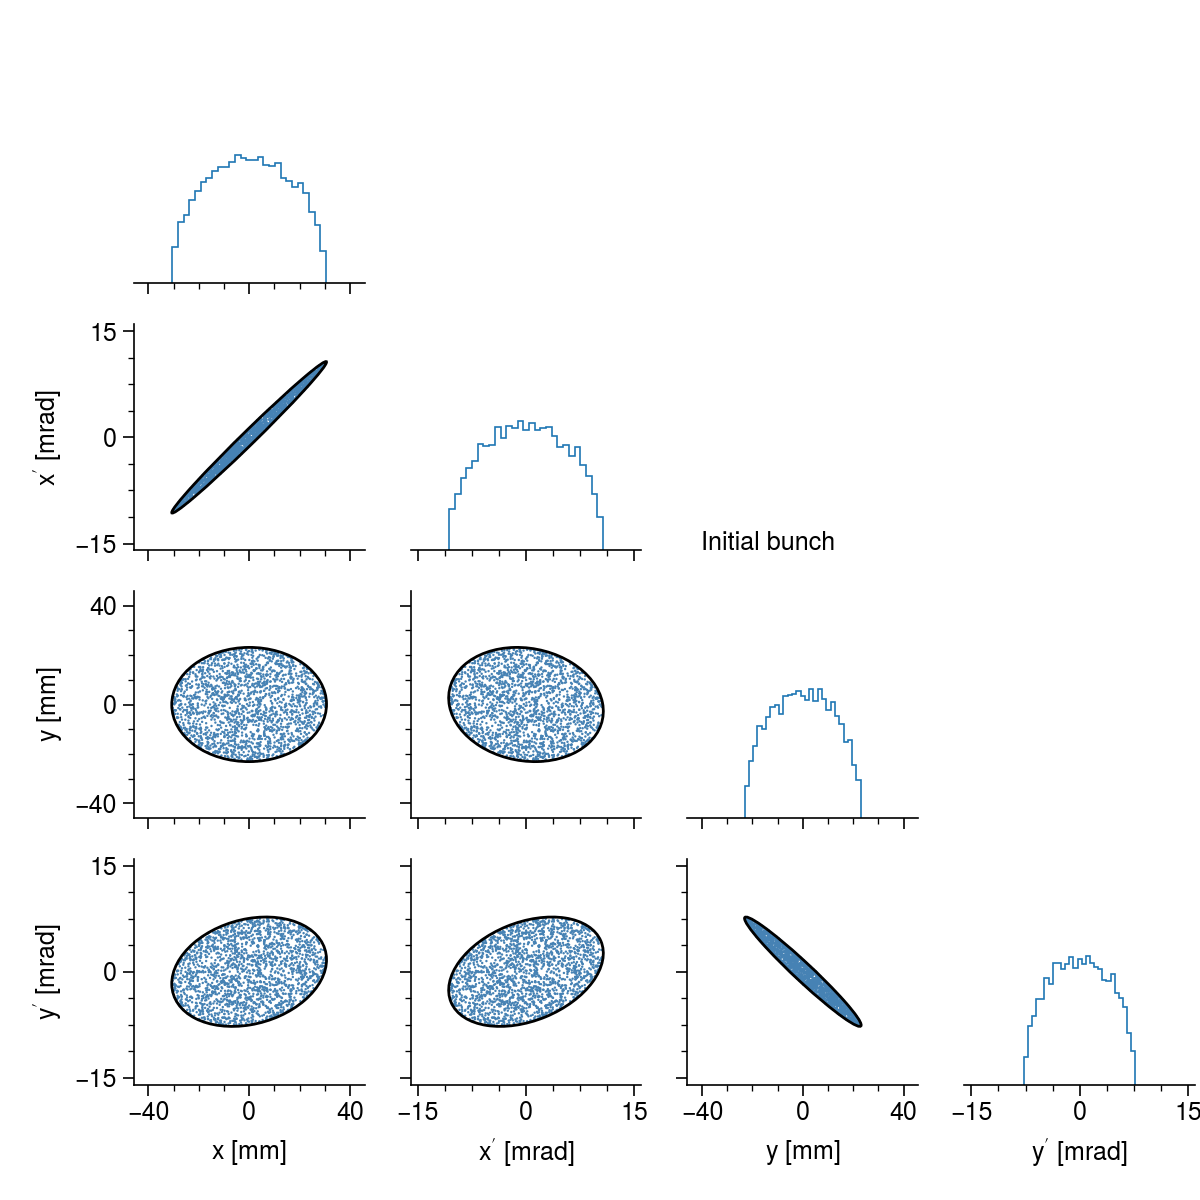

In [31]:
myplt.corner(X0, moments=True, text='Initial bunch');
save('initial_dist')

## Reconstruction

Form coefficent and observation arrays.  

In [32]:
A, b = [], []
for M, (x2, y2, xy) in zip(transfer_mats, moments):
    A.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
    A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3], 0, 0, 0, 0])
    A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
    b.append(x2)
    b.append(y2)
    b.append(xy)
A, b = np.array(A), np.array(b)


Sigma =
⎡236.107  81.59    0.924   13.015 ⎤
⎢                                 ⎥
⎢ 81.59   28.621  -7.237    6.957 ⎥
⎢                                 ⎥
⎢ 0.924   -7.237  134.027  -43.579⎥
⎢                                 ⎥
⎣13.015   6.957   -43.579   14.92 ⎦

Sigma0 =
⎡236.045  81.57     0.9    13.017 ⎤
⎢                                 ⎥
⎢ 81.57   28.614  -7.244    6.958 ⎥
⎢                                 ⎥
⎢  0.9    -7.244  133.978  -43.563⎥
⎢                                 ⎥
⎣13.017   6.958   -43.563  14.915 ⎦

Sigma - Sigma0 =
⎡0.062   0.021  0.024   -0.003⎤
⎢                             ⎥
⎢0.021   0.007  0.006    0.0  ⎥
⎢                             ⎥
⎢0.024   0.006  0.049   -0.015⎥
⎢                             ⎥
⎣-0.003   0.0   -0.015  0.005 ⎦


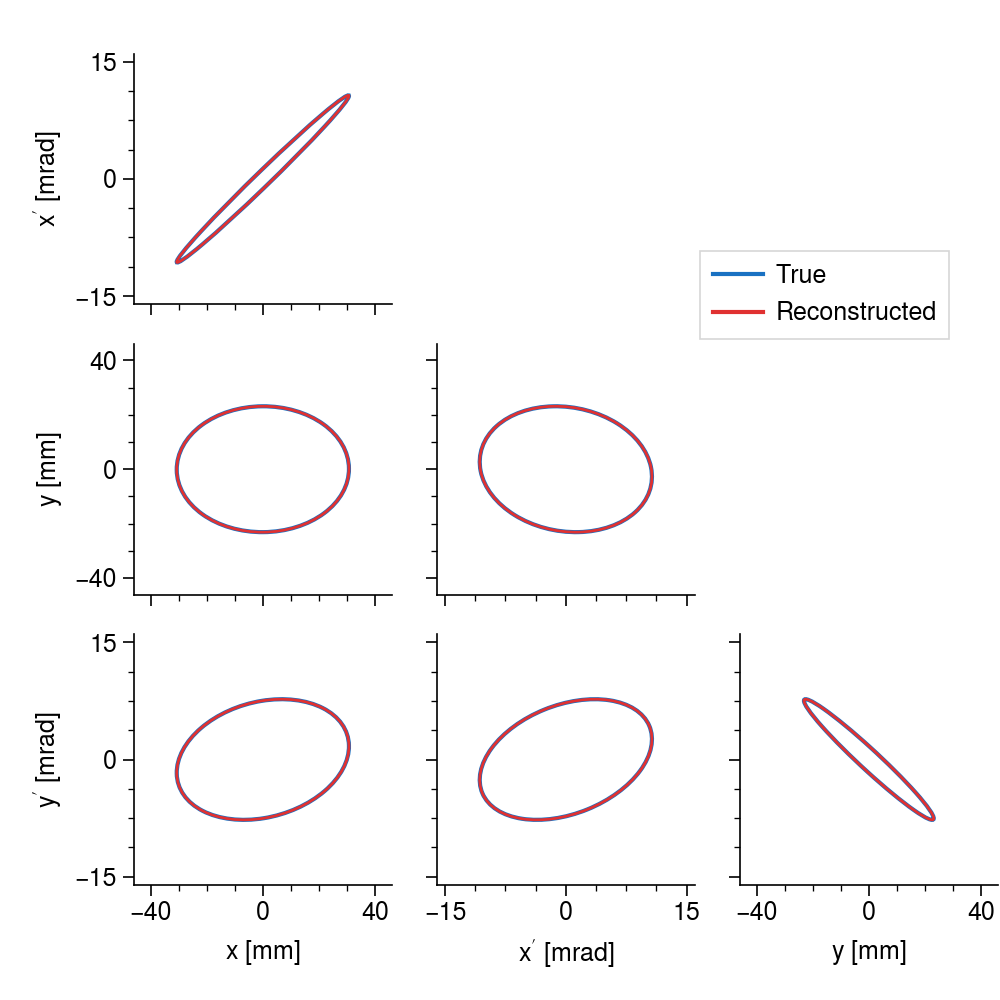

In [35]:
guess = to_vec(Sigma0) 
Sigma = reconstruct_moments(A, b)
print()
show(Sigma, 'Sigma')
print()
show(Sigma0, 'Sigma0')
print()
show(Sigma - Sigma0, 'Sigma - Sigma0')

axes = myplt.rms_ellipses(Sigma0, color='blue8', lw=1.5);
axes = myplt.rms_ellipses(Sigma, axes=axes, color='red8', lw=1)
handles = [Line2D([0], [0], color='blue8'), Line2D([0], [0], color='red8')]
axes[1, 1].legend(handles, ['True', 'Reconstructed'], loc=(1.02, 1.02));
save('projection_default')

## Measurement Errors 

Here we add Gaussian noise to each measured moment.

In [36]:
eps_ideal = ea.intrinsic_emittances(Sigma0)
emittances, Sigmas = {}, {}

In [37]:
def plot_emittance_comparison(varied_parameters, emittances, xlabel='', figname=None):
    emittances = np.array(emittances)
    fig, ax = plot.subplots(figsize=(5.5, 2.5))
    for i, color in enumerate(['green8', 'pink8']):
        ax.axhline(eps_ideal[i], ls='-', lw=1, color=color, alpha=0.2)
        ax.scatter(varied_parameters, emittances[:, i], c=color, s=10)
    ax.format(xlabel=xlabel, ylabel='[mm $\cdot$ mrad]', title='Reconstructed intrinsic emittance', grid=False)
    ax.legend(labels=[r'$\varepsilon_{1, true}$', r'$\varepsilon_{2, true}$', 
                      r'$\varepsilon_{1, meas}$', r'$\varepsilon_{2, meas}$'], ncols=1, loc=(1.02, 0))
    if figname:
        save(figname)
    plt.show()
    
def plot_moment_comparison(varied_parameters, Sigmas, Sigma0, xlabel='', figname=None):
    fig, ax = plot.subplots(figsize=(5.5, 2.5))
    Sigmas = np.array(Sigmas)
    colors = ['blue8', 'orange6', 'green8']
    for color, i, j in zip(colors, [0, 2, 0], [0, 2, 2]):
        ax.axhline(Sigma0[i, j], color=color, alpha=0.2)
        ax.scatter(varied_parameters, Sigmas[:, i, j], marker='.', c=color);
    ax.format(xlabel=xlabel, ylabel='[mm$^2$]', title='Reconstructed moments', grid=False)
    ax.legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], ncols=1, loc=(1.02, 0));
    if figname:
        save(figname)
    plt.show()
    
def plot_all_moments_comparison(varied_parameters, Sigmas, Sigma0, xlabel='', figname=None):
    fig, axes = plot.subplots(nrows=4, ncols=4, figsize=(10, 6), sharey=False, spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel=xlabel, suptitle='Reconstructed moments', grid=False)
    Sigmas = np.array(Sigmas)
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            ax.axhline(Sigma0[i, j], color='red8', alpha=0.2)
            ax.scatter(varied_parameters, Sigmas[:, i, j], marker='.', c='k')
            ax.format(title=utils.get_moments_label(i, j))
    myplt.set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    myplt.set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    myplt.set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    myplt.set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    if figname:
        save(figname)
    plt.show()

In [39]:
def blur(array, stdev=1.0, mean=0.0):
    return array + np.random.normal(loc=mean, scale=stdev, size=b.shape)

guess = to_vec(Sigma0)
stdev_min, stdev_max = (0.0, 16.0) # [mm^2]
nsteps = 25
trials_per_step = 3

stdevs = np.repeat(np.linspace(stdev_min, stdev_max, nsteps), trials_per_step)
emittances['meas_err'], Sigmas['meas_err'] = [], []
for stdev in tqdm(stdevs):
    Sigma = reconstruct_moments(A, blur(b, stdev))
    emittances['meas_err'].append(ea.intrinsic_emittances(Sigma))
    Sigmas['meas_err'].append(Sigma)

100%|██████████| 75/75 [00:00<00:00, 1819.11it/s]


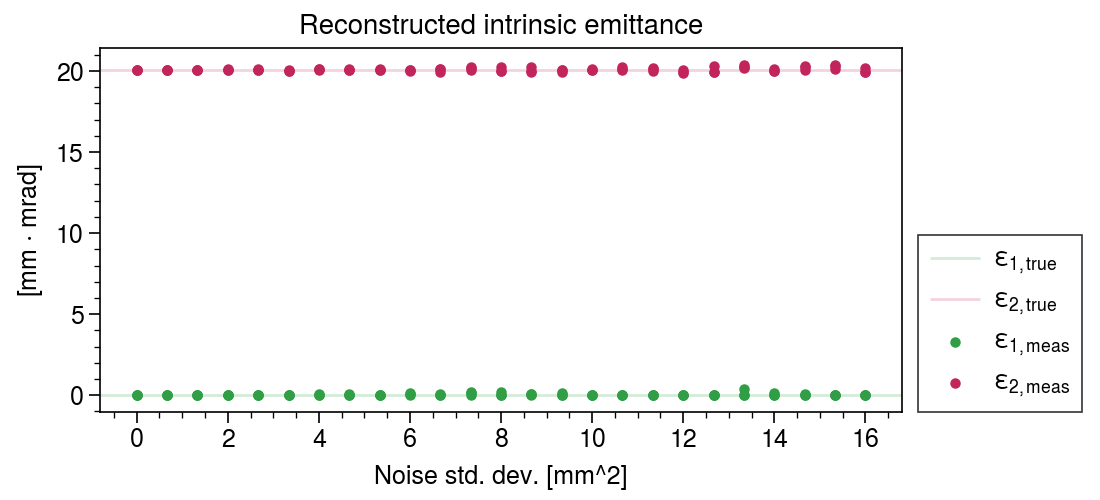

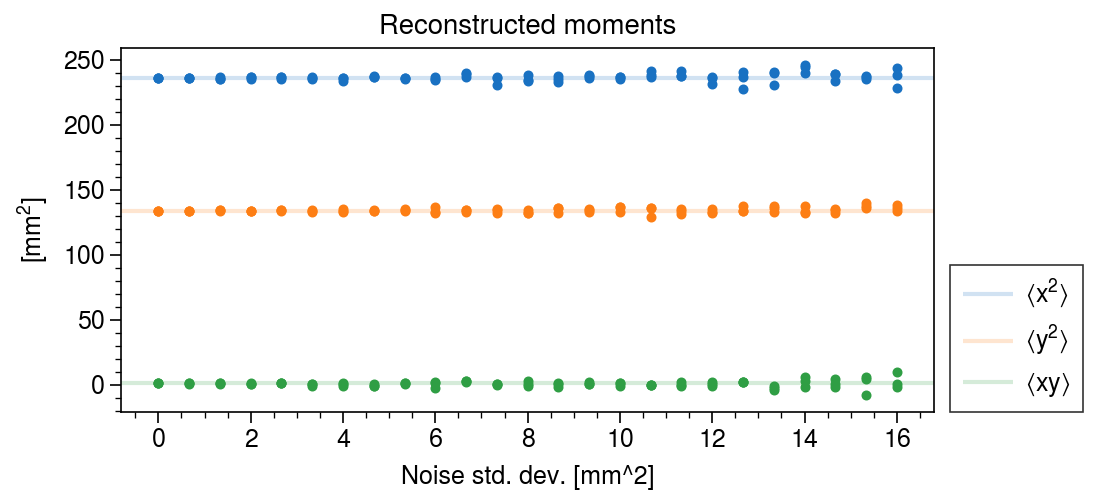

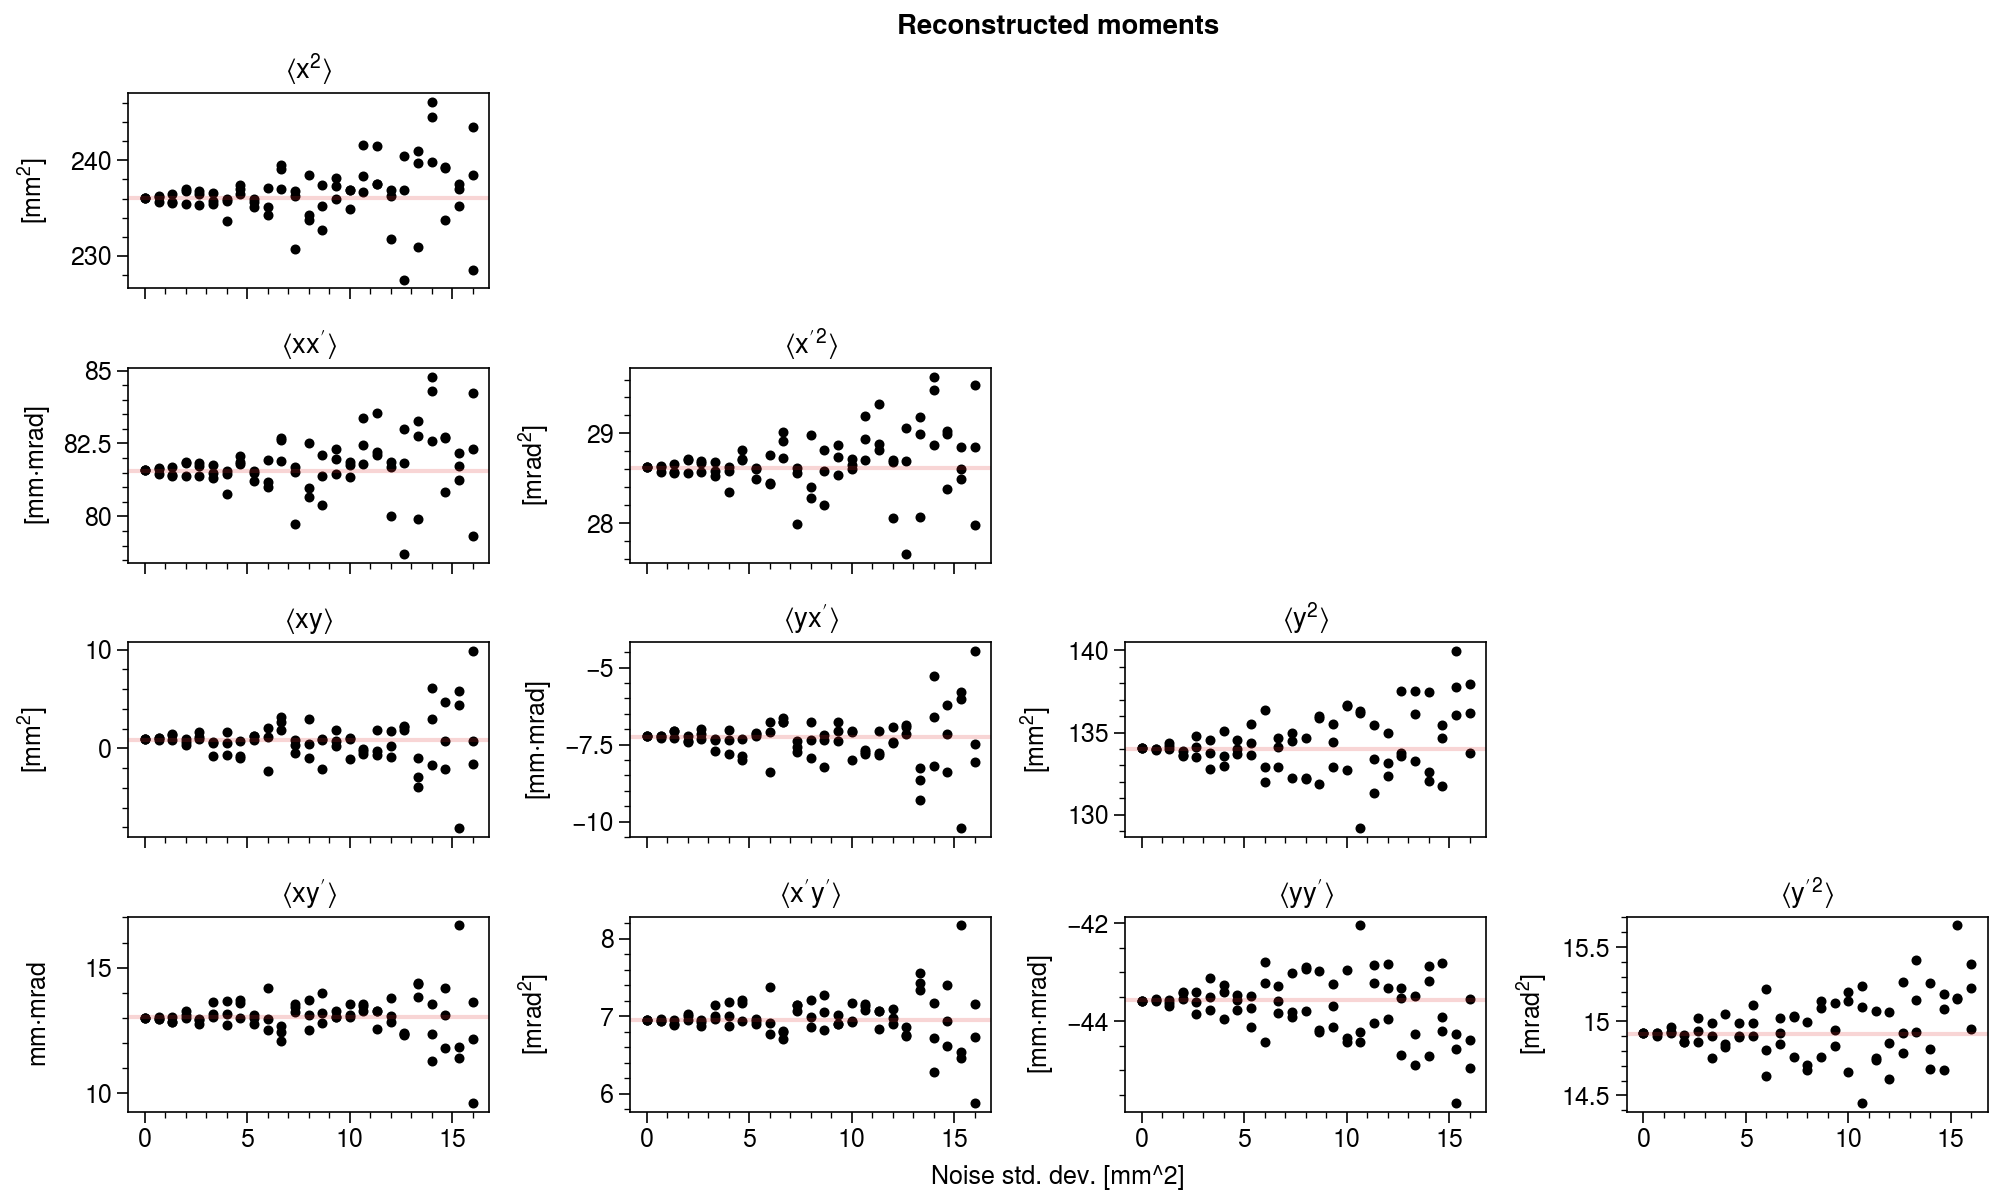

In [40]:
xlabel = 'Noise std. dev. [mm^2]'
plot_emittance_comparison(stdevs, emittances['meas_err'], xlabel, figname='emittance_meas_err')
plot_moment_comparison(stdevs, Sigmas['meas_err'], Sigma0, xlabel, figname='moments_meas_err')
plot_all_moments_comparison(stdevs, Sigmas['meas_err'], Sigma0, xlabel, figname='moments_all_meas_err')

## Comments 